In [1]:
import requests
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from statsmodels.graphics.tsaplots import plot_pacf

# **An Exploration of Forecasting**
This notebook serves as a playground to teach myself forecasting techniques.

Note that all code has been inspired by the following Kaggle Tutorial Notebook. https://www.kaggle.com/learn/time-series

This notebook supplied valuable graphing code, and tutorials that worked

## **Data Loading**

### **Imports**

In [2]:
class cartoApi:

    def __init__(self,query,format = "CSV") -> None:
        self.base              = "https://phl.carto.com/api/v2/sql?q="
        self.query             = query
        self.format            = format
        self.request_plain     = f"{self.base}{self.query}&format={self.format}"
        self.request_url       = f"{self.base}{urllib.parse.quote_plus(self.query)}&format={self.format}"

    def queryRequest(self):
        request = requests.get(self.request_url)
        return request.content

    def queryDataframe(self):
        data = pd.read_csv(self.request_url)
        return(data)

In [3]:
#shootings      = SELECT * FROM shootings WHERE date_ >= '1/1/2020'
#threeOneOne    = SELECT * FROM public_cases_fc WHERE requested_datetime >= '1/1/2020'

api_call = cartoApi(query="SELECT * FROM shootings WHERE date_ >= '1/1/2020'")
df = api_call.queryDataframe()
#df.head(10)

In [4]:
print(len(df.index))
df["date_only"] = pd.to_datetime(df["date_"]).dt.date
#print(df["date_only"].head(10))

9491


In [5]:
grouped = df.groupby(by="date_only").count()
grouped.reset_index(inplace=True)
grouped = grouped[["date_only", "the_geom"]].rename(columns={"the_geom":"count"})
grouped.head()

,date_only,count
0,2020-01-01,6
1,2020-01-02,2
2,2020-01-03,2
3,2020-01-04,4
4,2020-01-06,1


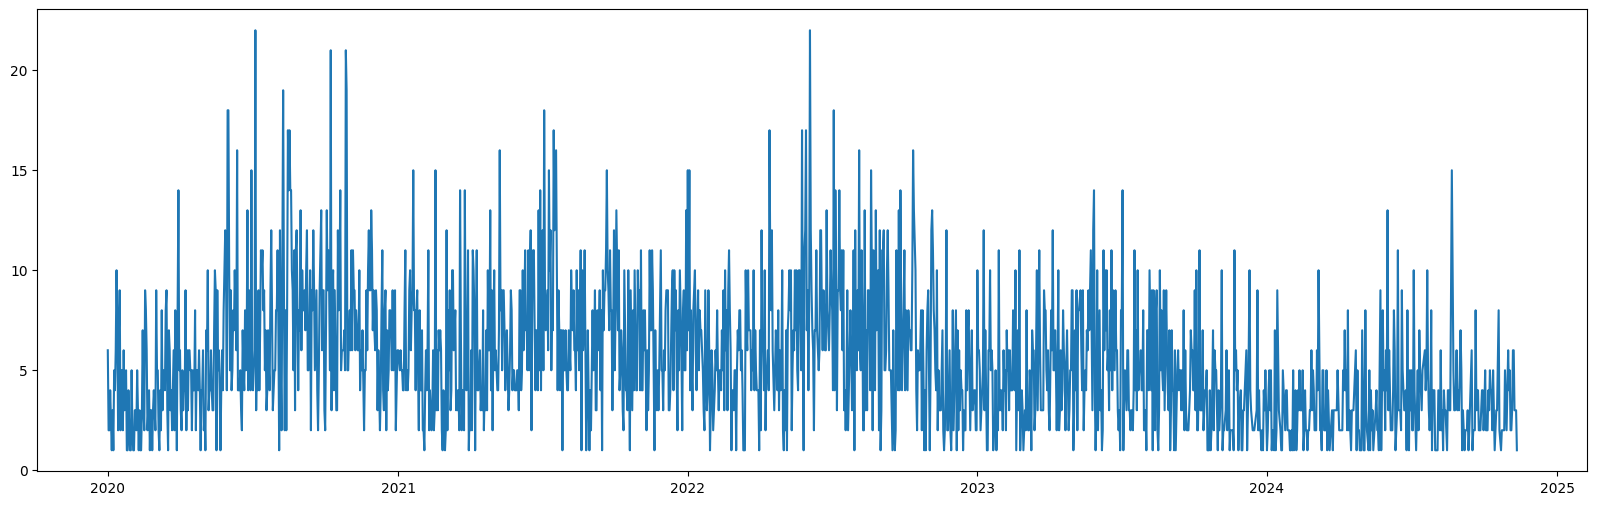

In [6]:
plt.subplots(figsize=(20, 6))
plt.plot(grouped["date_only"], grouped["count"])
plt.show()

## **Visualizing and Trend Hunting**
In this section we will attempt to uncover any trends behing the madness of violent crime.

In [7]:
# annotations: https://stackoverflow.com/a/49238256/5769929
# code borrowed from https://www.kaggle.com/code/ryanholbrook/trend
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

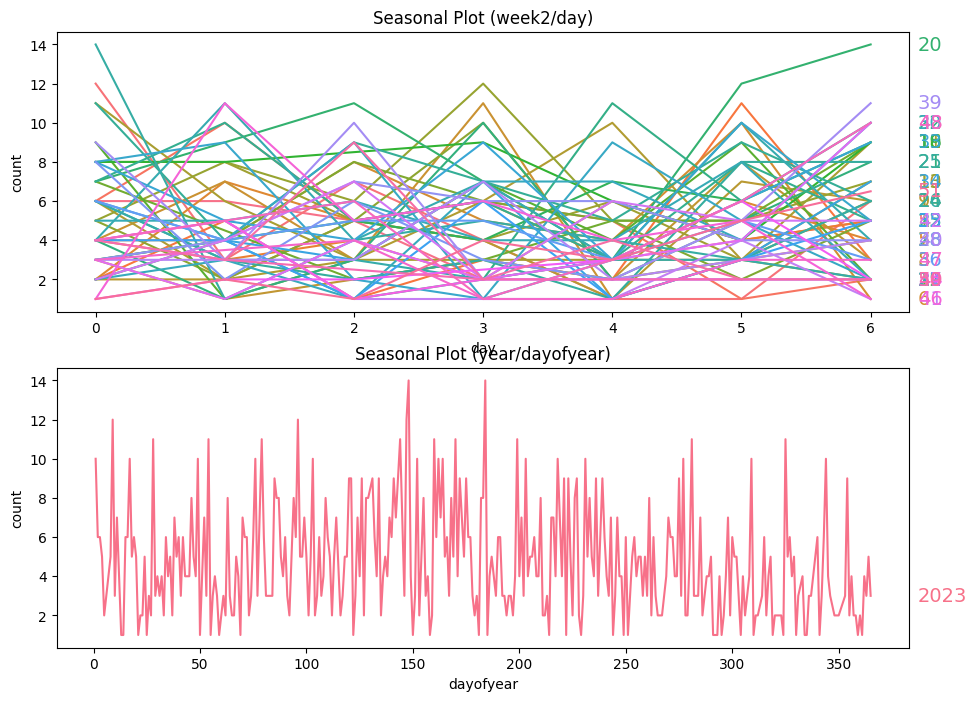

In [8]:
X = grouped.copy()
X.rename(columns={"date_only":"date"}, inplace=True)
X["date"] = pd.to_datetime(X["date"])

#limit this to only last year
X = X.loc[X.date.dt.year==2023, ["date", "count"]]

# annotation https://www.kaggle.com/code/ryanholbrook/seasonality
# days within a week
X["day"] = X.date.dt.dayofweek  # the x-axis (freq)
X["week"] = X.date.dt.isocalendar().week  # the seasonal period (period)
X["week2"] = X.week.astype(int)

# days within a year
X["dayofyear"] = X.date.dt.dayofyear
X["year"] = X.date.dt.year

#palette = sns.color_palette("Set1", n_colors=52)
#sns.lineplot(x=X.day, y=X.count, hue=X.week2, palette=palette)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 8))
seasonal_plot(X, y="count", period="week2", freq="day", ax=ax0)
seasonal_plot(X, y="count", period="year", freq="dayofyear", ax=ax1);

From the above graphs we can see that there is no real trend to the week, or to the day of the year.  We often hear that crime goes up in the summer, however, that may only be marginally true in our case, if at all.

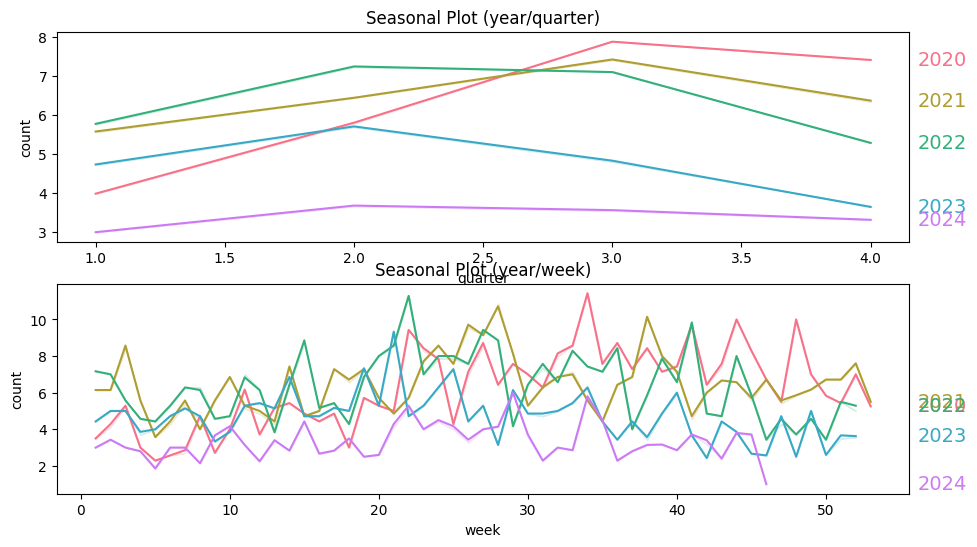

In [9]:
# Now we are going to look into quartly trends as well as weeks in the year as a sort of "season"
# reset X
del X
X = grouped.copy()
X.rename(columns={"date_only":"date"}, inplace=True)
X["date"] = pd.to_datetime(X["date"])

# quarters within a year
X["quarter"] = X.date.dt.quarter
X["year"] = X.date.dt.year

# weeks in a year
X["week"] = X.date.dt.isocalendar().week  # the seasonal period (period)
X["week"] = X.week.astype(int)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="count", period="year", freq="quarter", ax=ax0)
seasonal_plot(X, y="count", period="year", freq="week", ax=ax1);

Seasonal plots seem to show a slight bump in the late spring through the summer,but i believe its over shawdowed by the rise in crime during the pandemic.

## **Periodogram**
Hunting for variance(or lack ther of) in seasonality.

In [10]:
# this function borrowed from https://www.kaggle.com/code/ryanholbrook/seasonality
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    ts = ts.to_numpy().squeeze()
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

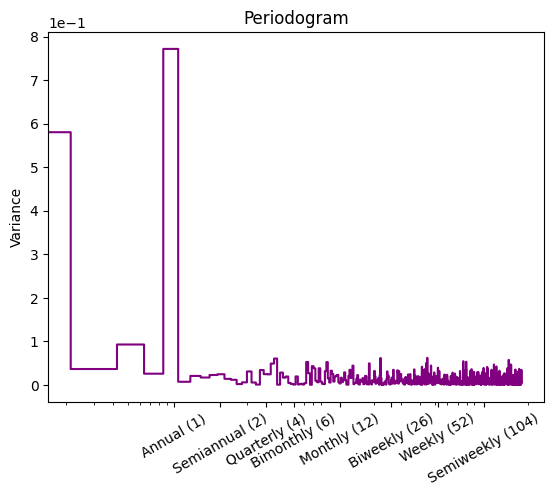

In [11]:
del X
X = grouped.copy()
X.rename(columns={"date_only":"date"}, inplace=True)
X["date"] = pd.to_datetime(X["date"])
X = X.set_index("date").to_period("D")

plot_periodogram(X)

The above periodogram shows there there is really no strong trends to be drawn, except for annually.  This could be because of the previously mentioned pandemic bump, but we will try annual seasonality when modeling.

In [12]:
fourier = CalendarFourier(freq="YE", order=2)  # 2 sin/cos pairs for (YE)annual seasonality
y = X["count"]
dp = DeterministicProcess(
    index=X.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

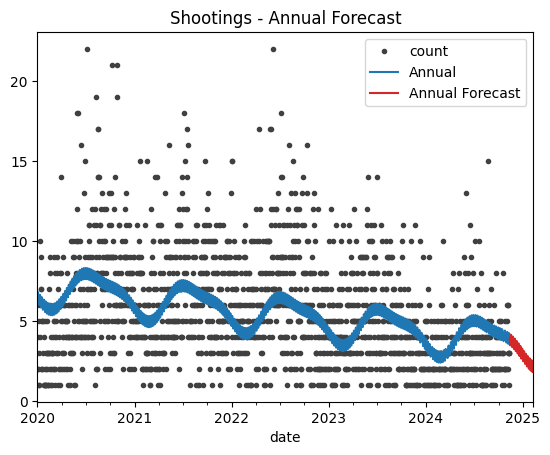

In [13]:
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Shootings - Annual Forecast")
ax = y_pred.plot(ax=ax, label="Annual")
ax = y_fore.plot(ax=ax, label="Annual Forecast", color='C3')
_ = ax.legend()

## **Create Lags**
This section will seek to create lags, which will allow a model to look back at the previous *n* y values, giving the models a little more information on the current goings on.

This may not be the most efficient implementation, but I believe it is a good starting point.

In [14]:
s = grouped.iloc[:,1]
df = pd.concat([grouped["date_only"], s, s.shift().rename('count_lag1'), s.shift(2).rename('count_lag2')], axis=1)
df.dropna(inplace=True)
df.astype(dtype={"count_lag1":"int","count_lag2":"int"})

,date_only,count,count_lag1,count_lag2
2,2020-01-03,2,2,6
3,2020-01-04,4,2,2
4,2020-01-06,1,4,2
5,2020-01-07,3,1,4
6,2020-01-08,1,3,1
...,...,...,...,...
1707,2024-11-07,6,6,3
1708,2024-11-08,3,6,6
1709,2024-11-09,3,3,6
1710,2024-11-10,3,3,3


In [15]:
df.set_index(
    pd.PeriodIndex(df.date_only, freq="W"),
    inplace=True,
)
df.drop("date_only", axis=1, inplace=True)

### Plotting Lags

Plotting functions accreddited to https://www.kaggle.com/code/ryanholbrook/time-series-as-features

In [16]:
from warnings import simplefilter

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

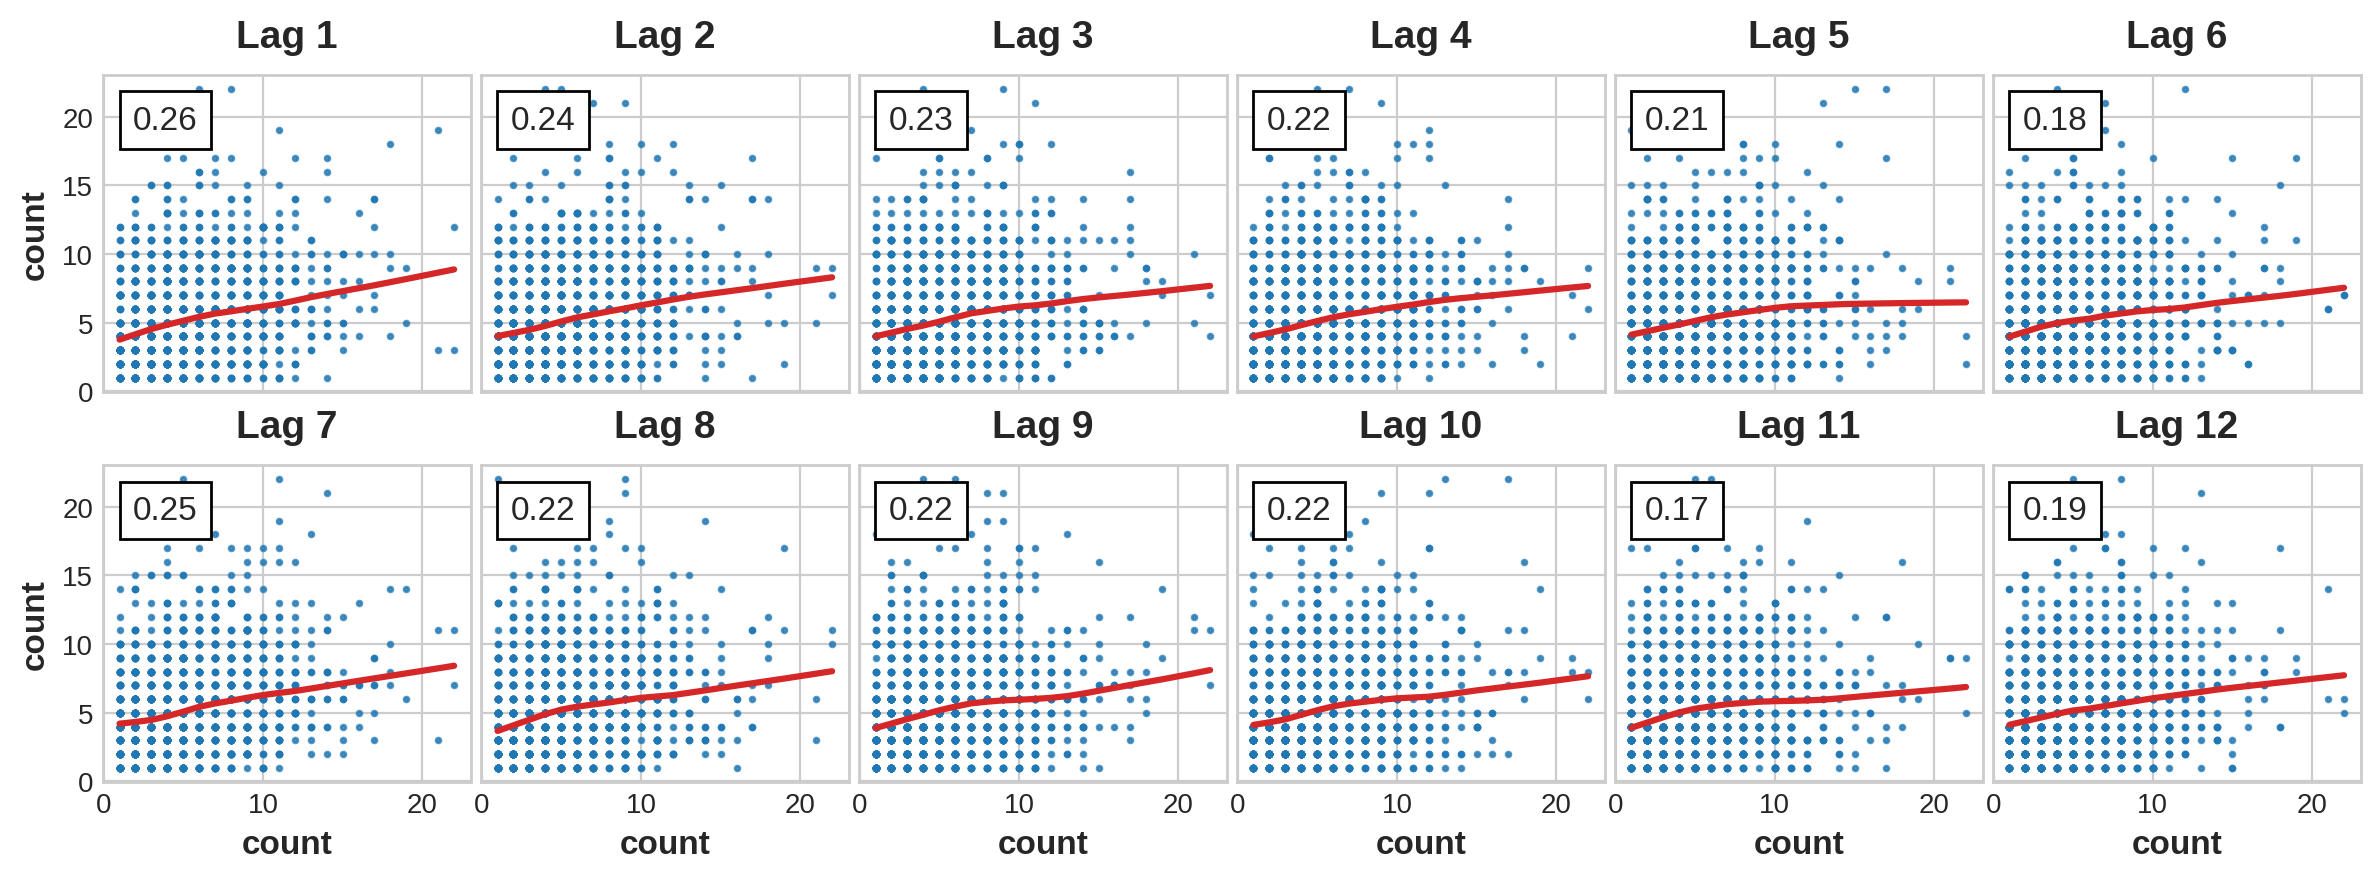

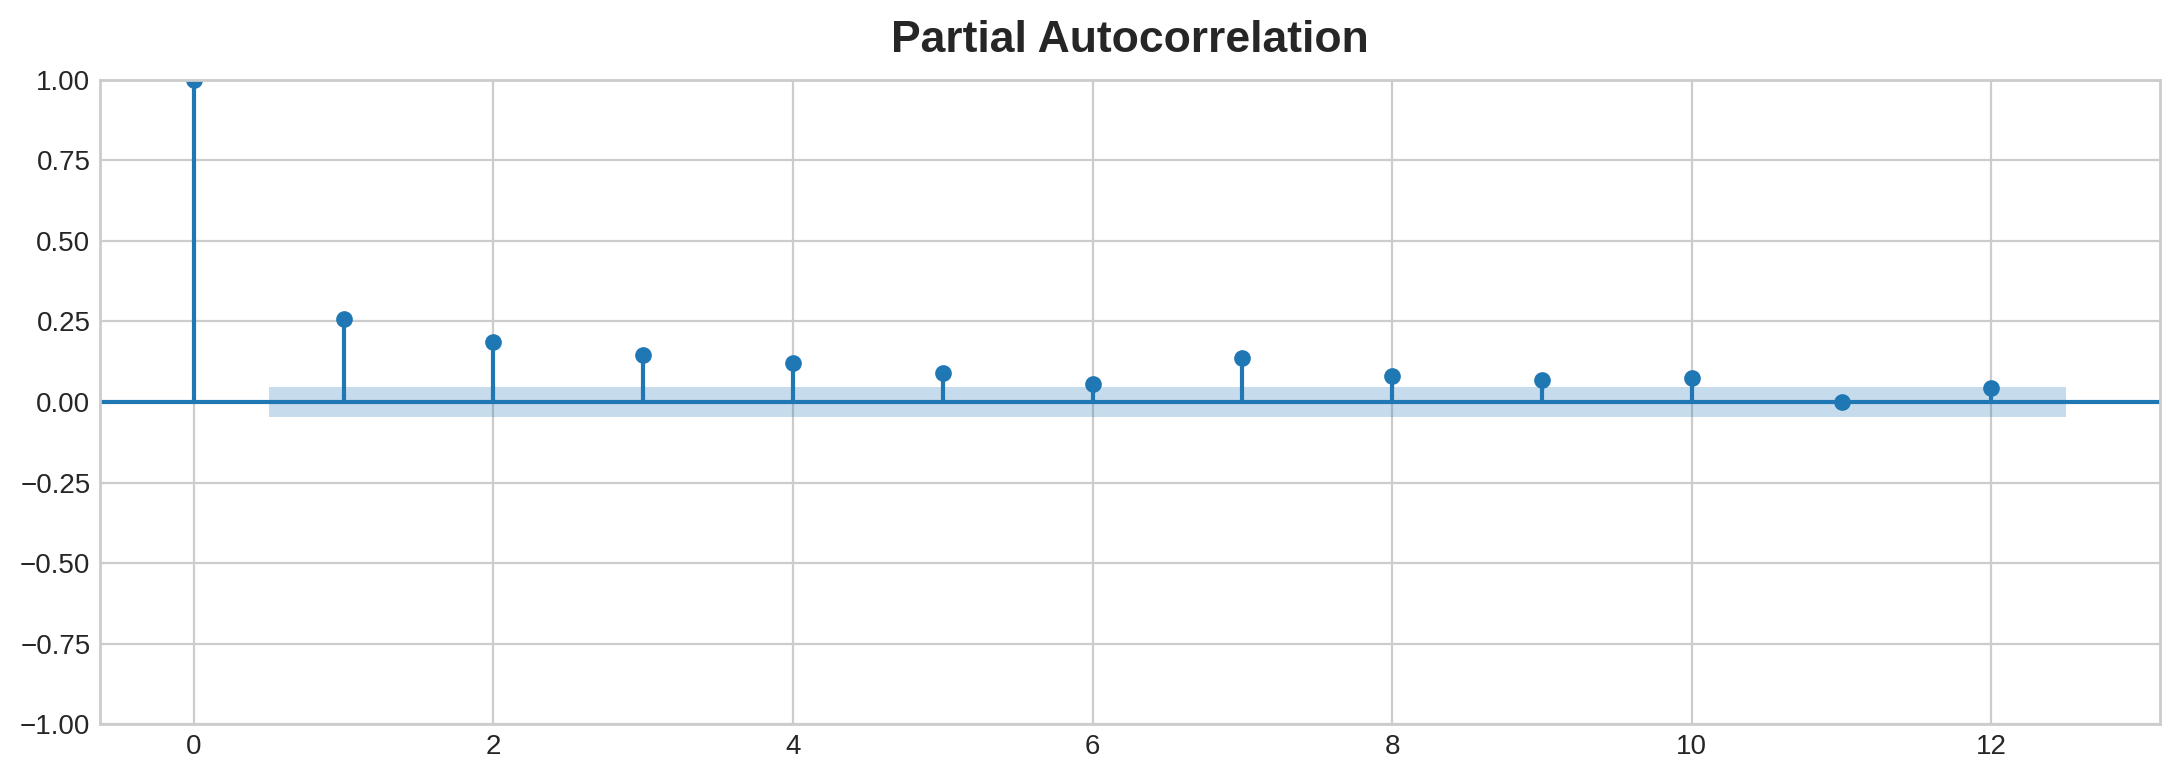

In [17]:
#ax = df.count.plot(title='Shooting Trends', **plot_params)
#_ = ax.set(ylabel="Number of Shootings")

_ = plot_lags(df["count"], lags=12, nrows=2)
_ = plot_pacf(df["count"], lags=12)

From the above graphs we can see that lags are not really going to be beneficial to predicting future state.  This may imply the randomness to these crimes, or perhaps a lack of retaliation?  It makes us wonder if philly does truly have heart.  Are these acts of violence a sort of last stand?  When the straw that breaks the camels back falls and there is no other option?  It makes me a little sad.  Maybe there is brotherly love.

In [18]:
def create_lags(df, y_col, lags=2):
    for i in range(1, lags + 1):
        df[f"{y_col}_lag{i}"] = df[y_col].shift(i)
    return df

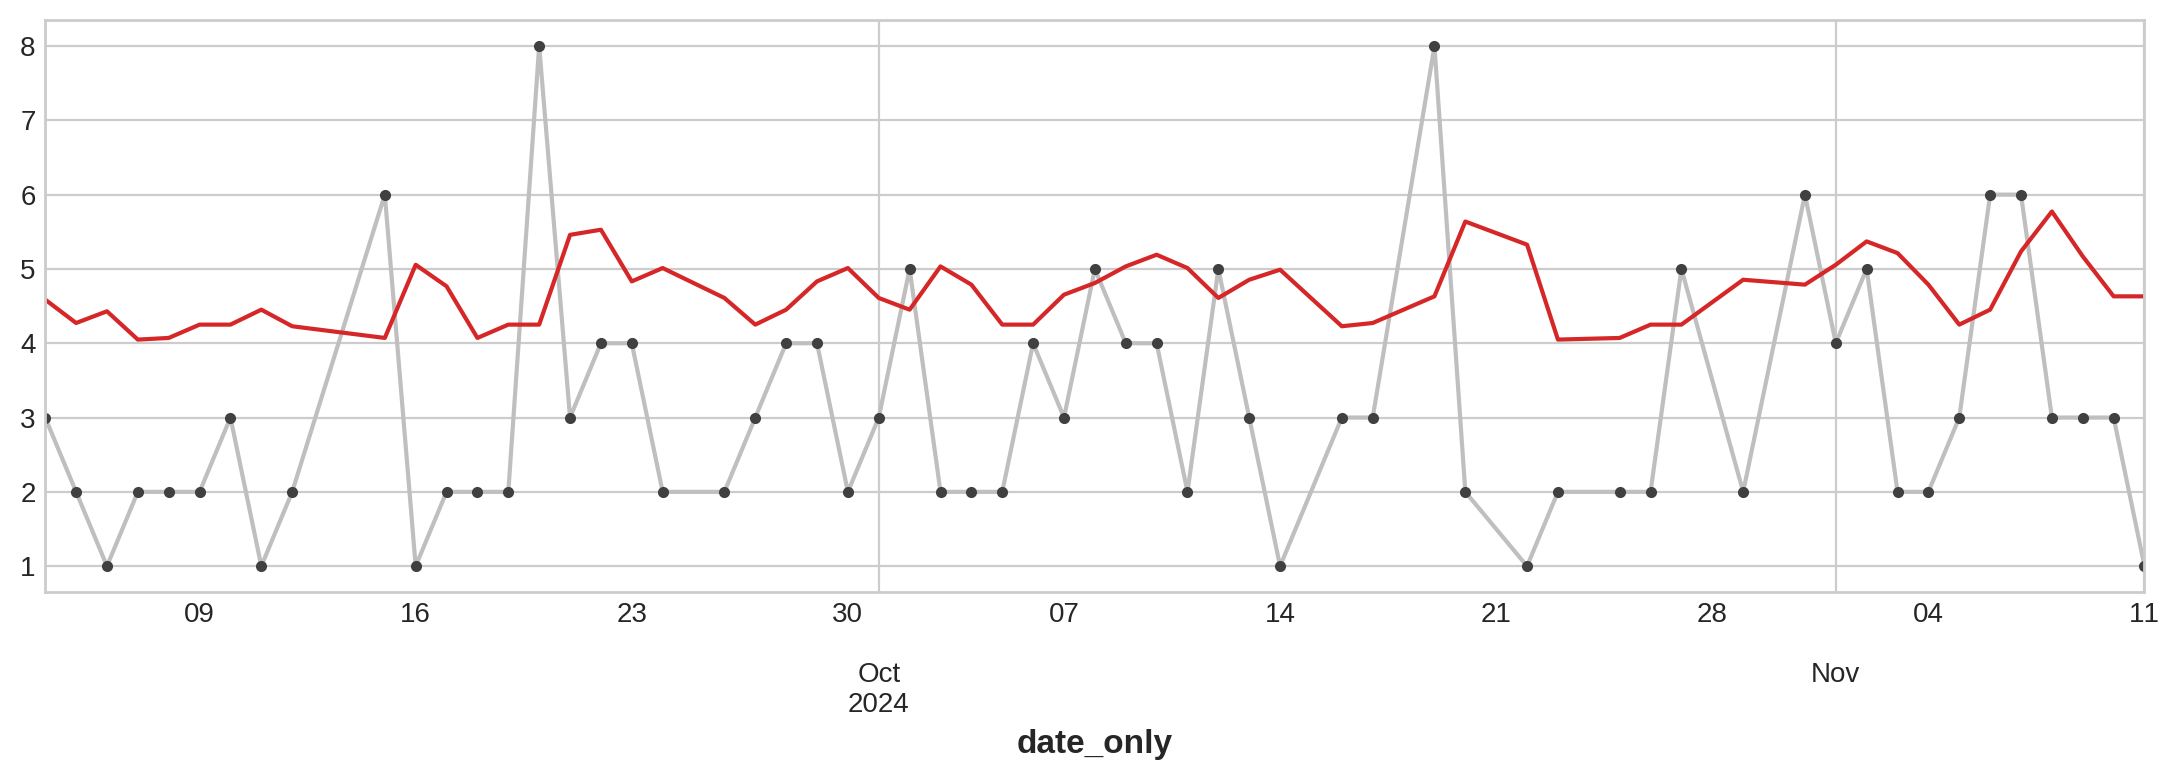

In [19]:
df = grouped.copy()
df = create_lags(df, "count", 2)
df.set_index(
    pd.PeriodIndex(df.date_only, freq="D"),
    inplace=True,
)

X = df.drop(["count", "date_only"], axis=1)
y = df["count"]
X = X.fillna(0.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

it seems that the model likes to predict high. Maybe residuals could help here.

## **Residuals and Hybrid model**